In [37]:
from tqdm.auto import tqdm

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import mutual_info_score
from sklearn.metrics import accuracy_score

from sklearn.metrics import auc
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score

from sklearn.model_selection import KFold



In [2]:
data = 'https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv'

!wget $data

--2022-10-05 19:24:04--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/AER_credit_card_data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.109.133, 185.199.110.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.109.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 73250 (72K) [text/plain]
Saving to: ‘AER_credit_card_data.csv’

AER_credit_card_dat 100%[===================>]  71.53K  --.-KB/s    in 0.07s   

2022-10-05 19:24:05 (992 KB/s) - ‘AER_credit_card_data.csv’ saved [73250/73250]



In [5]:
df = pd.read_csv('AER_credit_card_data.csv')

df.T.head(100)

,0,1,2,3,4,5,6,7,8,9,...,1309,1310,1311,1312,1313,1314,1315,1316,1317,1318
card,yes,yes,yes,yes,yes,yes,yes,yes,yes,yes,...,yes,yes,no,no,no,yes,no,yes,yes,yes
reports,0,0,0,0,0,0,0,0,0,0,...,1,0,0,0,1,0,5,0,0,0
age,37.66667,33.25,33.66667,30.5,32.16667,23.25,27.91667,29.16667,37.0,28.41667,...,40.16667,30.58333,39.33333,22.58333,30.33333,33.58333,23.91667,40.58333,32.83333,48.25
income,4.52,2.42,4.5,2.54,9.7867,2.5,3.96,2.37,3.8,3.2,...,2.0,2.512,2.3004,3.86,2.18,4.566,3.192,4.6,3.7,3.7
share,0.03327,0.005217,0.004156,0.065214,0.067051,0.044438,0.012576,0.076434,0.245628,0.01978,...,0.254827,0.002627,0.000522,0.000311,0.00055,0.002146,0.000376,0.026513,0.008999,0.111619
expenditure,124.9833,9.854167,15.0,137.8692,546.5033,91.99667,40.83333,150.79,777.8217,52.58,...,424.6292,4.583333,0.0,0.0,0.0,7.333333,0.0,101.2983,26.99667,344.1575
owner,yes,no,yes,no,yes,no,no,yes,yes,no,...,yes,no,no,no,no,yes,no,yes,no,yes
selfemp,no,no,no,no,no,no,no,no,no,no,...,no,yes,yes,no,yes,no,no,no,yes,no
dependents,3,3,4,0,2,0,2,0,0,0,...,1,3,0,1,0,0,3,2,0,2
months,54,34,58,25,64,54,7,77,97,65,...,121,36,46,36,13,94,12,1,60,2


#### EDA - Data Prep

In [6]:
df.dtypes

card            object
reports          int64
age            float64
income         float64
share          float64
expenditure    float64
owner           object
selfemp         object
dependents       int64
months           int64
majorcards       int64
active           int64
dtype: object

In [7]:

columns = df.columns

categorical_columns = list(df.dtypes[df.dtypes == 'object'].index)

for c in categorical_columns:
    df[c] = df[c].str.lower().str.replace(' ','_')


In [8]:
numerical = [c for c in columns if c not in categorical_columns]
categorical = [c for c in categorical_columns if c != 'card']

In [11]:
for c in numerical:
    print(c,':', df[c].dtype)

reports : int64
age : float64
income : float64
share : float64
expenditure : float64
dependents : int64
months : int64
majorcards : int64
active : int64


In [12]:
for c in categorical:
    print(c,':',df[c].dtype)

owner : object
selfemp : object


In [13]:
label = 'card'
df[label] = (df[label] == 'yes').astype(int)

df[label].value_counts() #class-imbalance

1    1023
0     296
Name: card, dtype: int64

In [14]:
features = ["reports", "age", "income", "share", "expenditure", "dependents", "months", "majorcards", "active", "owner", "selfemp"]
len(features), len(categorical), len(numerical)

(11, 2, 9)

#### Training , Validation & Testing Data

In [15]:
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1)

df_train = df_train.reset_index(drop = True)
df_val = df_val.reset_index(drop = True)
df_test = df_test.reset_index(drop = True)

y_train = df_train.card.values
y_val = df_val.card.values
y_test = df_test.card.values

del df_train['card']
del df_val['card']
del df_test['card']

#### Question 1

ROC AUC could also be used to evaluate feature importance of numerical variables.

Let's do that

* For each numerical variable, use it as score and compute AUC with the card variable.
* Use the training dataset for that.

In [19]:
for c in numerical:
    auc_score = roc_auc_score(y_train, df_train[c].values)
    if auc_score < 0.5:
        auc_score = roc_auc_score(y_train, -df_train[c].values)

    print(f'numeric feature : {c}, AUC : {auc_score}')

numeric feature : reports, AUC : 0.7166629860689376
numeric feature : age, AUC : 0.5240020979407055
numeric feature : income, AUC : 0.5908049467233478
numeric feature : share, AUC : 0.989183643423692
numeric feature : expenditure, AUC : 0.991042345276873
numeric feature : dependents, AUC : 0.5327757227773791
numeric feature : months, AUC : 0.5294217780967629
numeric feature : majorcards, AUC : 0.5343859842838476
numeric feature : active, AUC : 0.6043173411362006


#### Training the Model

In [20]:
#one-hot encoding
dv  = DictVectorizer(sparse=False)
train_dict = df_train[numerical + categorical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)


In [21]:
#Training Logistic Regreassion Model
model = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
model.fit(X_train, y_train)

LogisticRegression(max_iter=1000, solver='liblinear')

In [22]:
#validation of the model
val_dict = df_val[numerical + categorical].to_dict(orient='records')
X_val = dv.transform(val_dict)

y_val_pred = model.predict_proba(X_val)[:,1]
churn_pred = (y_val_pred >= 0.5)

accuracy = round((y_val == churn_pred).mean(), 4)
accuracy

0.9697

In [23]:
accuracy_score(y_val, churn_pred)

0.9696969696969697

In [24]:
#The above accuracies would not matter as there is class imbalance

#### Question - 2

* What's the AUC of this model on the validation dataset? (round to 3 digits)

In [26]:
#AUC score of the model
round(roc_auc_score(y_val, y_val_pred),3)

0.995

#### Question - 3

Now let's compute precision and recall for our model.

* Evaluate the model on the validation dataset on all thresholds from 0.0 to 1.0 with step 0.01
* For each threshold, compute precision and recall
* Plot them

At which threshold precision and recall curves intersect?


#### Precision & Recall

* precision - fraction of positive prediction which is correct
* precision, $P = TP/(TP + FP)$
    * TP - True Positive
    * FP - False Positive

</br>

* recall - fraction of positive outcomes which is predicted correctly
* recall - $r = TP/(TP + FN)$
    * TP - True Positive
    * FN - False Negative

In [27]:
thresholds = np.linspace(0,1,101)

thresholds

array([0.  , 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1 ,
       0.11, 0.12, 0.13, 0.14, 0.15, 0.16, 0.17, 0.18, 0.19, 0.2 , 0.21,
       0.22, 0.23, 0.24, 0.25, 0.26, 0.27, 0.28, 0.29, 0.3 , 0.31, 0.32,
       0.33, 0.34, 0.35, 0.36, 0.37, 0.38, 0.39, 0.4 , 0.41, 0.42, 0.43,
       0.44, 0.45, 0.46, 0.47, 0.48, 0.49, 0.5 , 0.51, 0.52, 0.53, 0.54,
       0.55, 0.56, 0.57, 0.58, 0.59, 0.6 , 0.61, 0.62, 0.63, 0.64, 0.65,
       0.66, 0.67, 0.68, 0.69, 0.7 , 0.71, 0.72, 0.73, 0.74, 0.75, 0.76,
       0.77, 0.78, 0.79, 0.8 , 0.81, 0.82, 0.83, 0.84, 0.85, 0.86, 0.87,
       0.88, 0.89, 0.9 , 0.91, 0.92, 0.93, 0.94, 0.95, 0.96, 0.97, 0.98,
       0.99, 1.  ])

In [28]:
precisions = []
recalls = []

for t in thresholds:
    actual_positive = (y_val == 1)
    actual_negative = (y_val == 0)

    predict_positive = (y_val_pred >= t)
    predict_negative = (y_val_pred < t)

    tru_pos = (predict_positive & actual_positive).sum()
    tru_neg = (predict_negative & actual_negative).sum()

    fal_pos = (predict_positive & actual_negative).sum()
    fal_neg =  (predict_negative & actual_positive).sum()

    precison = tru_pos / (tru_pos + fal_pos)
    recall = tru_pos / (tru_pos + fal_neg)

    precisions.append(precison)
    recalls.append(recall)

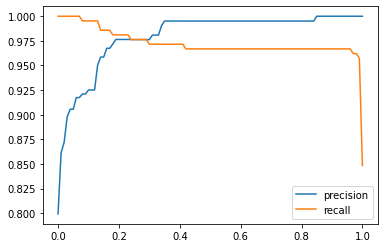

In [29]:
plt.plot(thresholds, precisions, label='precision')
plt.plot(thresholds, recalls, label='recall')
plt.legend()

In [32]:
for i in range(len(thresholds)):
    if round(precisions[i],4) == round(recalls[i],4):
        print('thresholds where precision matches with recall: ',thresholds[i])

thresholds where precision matches with recall:  0.24
thresholds where precision matches with recall:  0.25
thresholds where precision matches with recall:  0.26
thresholds where precision matches with recall:  0.27
thresholds where precision matches with recall:  0.28
thresholds where precision matches with recall:  0.29


#### Question 4

Precision and recall are conflicting - when one grows, the other goes down. That's why they are often combined into the F1 score - a metrics that takes into account both

This is the formula for computing $F_1$: 

$F_1 = 2*\frac{P*R}{P+R}$

Where $P is precision and $R$ is recall.

* Let's compute $F_1$ for all thresholds from 0.0 to 1.0 with increment 0.01 using the validation set

At which threshold $F_1$ is maximal?

In [34]:
F1 = 2 * (np.array(precisions) * np.array(recalls)) / (np.array(precisions) + np.array(recalls))

F1


array([0.88842105, 0.9254386 , 0.93156733, 0.94618834, 0.95045045,
       0.95045045, 0.9569161 , 0.9569161 , 0.95671982, 0.95671982,
       0.95890411, 0.95890411, 0.95890411, 0.97222222, 0.97196262,
       0.97196262, 0.97652582, 0.97652582, 0.97641509, 0.9787234 ,
       0.9787234 , 0.9787234 , 0.9787234 , 0.9787234 , 0.97630332,
       0.97630332, 0.97630332, 0.97630332, 0.97630332, 0.97630332,
       0.97387173, 0.97619048, 0.97619048, 0.97619048, 0.98086124,
       0.98321343, 0.98321343, 0.98321343, 0.98321343, 0.98321343,
       0.98321343, 0.98321343, 0.98076923, 0.98076923, 0.98076923,
       0.98076923, 0.98076923, 0.98076923, 0.98076923, 0.98076923,
       0.98076923, 0.98076923, 0.98076923, 0.98076923, 0.98076923,
       0.98076923, 0.98076923, 0.98076923, 0.98076923, 0.98076923,
       0.98076923, 0.98076923, 0.98076923, 0.98076923, 0.98076923,
       0.98076923, 0.98076923, 0.98076923, 0.98076923, 0.98076923,
       0.98076923, 0.98076923, 0.98076923, 0.98076923, 0.98076

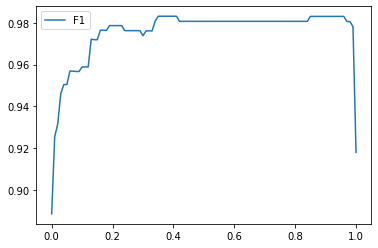

In [35]:
plt.plot(thresholds, F1, label='F1')
plt.legend()

#### Question 5

Use the `KFold` class from Scikit-Learn to evaluate our model on 5 different folds:

`KFold(n_splits=5, shuffle=True, random_state=1)`

* Iterate over different folds of df_full_train
* Split the data into train and validation
* Train the model on train with these parameters: `LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)`
* Use AUC to evaluate the model on validation

How large is standard devidation of the AUC scores across different folds?

In [36]:
def train(df_train, y_train, C=1.0):
    dicts = df_train[categorical + numerical].to_dict(orient='records')

    dv = DictVectorizer(sparse=False)
    X_train = dv.fit_transform(dicts)

    model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
    model.fit(X_train, y_train)
    
    return dv, model


def predict(df, dv, model):
    dicts = df[categorical + numerical].to_dict(orient='records')

    X = dv.transform(dicts)
    y_pred = model.predict_proba(X)[:, 1]

    return y_pred

In [39]:
kfold = KFold(n_splits=5, shuffle=True, random_state=1)


scores = []

for train_idx, val_idx in tqdm(kfold.split(df_full_train)):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.card.values
    y_val = df_val.card.values

    dv, model = train(df_train, y_train)
    y_pred = predict(df_val, dv, model)

    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

0it [00:00, ?it/s]

In [40]:
print('C=%s %.3f +- %.3f' % ("1.0", np.mean(scores), np.std(scores)))

C=1.0 0.996 +- 0.003


#### Question 6
Now let's use 5-Fold cross-validation to find the best parameter C

* Iterate over the following C values: `[0.01, 0.1, 1, 10]`
* Initialize KFold with the same parameters as previously
* Use these parametes for the model: `LogisticRegression(solver='liblinear', C=C, max_iter=1000)`
* Compute the mean score as well as the std (round the mean and std to 3 decimal digits)

Which C leads to the best mean score?

In [41]:
C_values = [0.01, 0.1, 1, 10]
n_splits = 5

for C in tqdm(C_values):
    kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

    scores = []

    for train_idx, val_idx in kfold.split(df_full_train):
        df_train = df_full_train.iloc[train_idx]
        df_val = df_full_train.iloc[val_idx]

        y_train = df_train.card.values
        y_val = df_val.card.values

        dv, model = train(df_train, y_train, C=C)
        y_pred = predict(df_val, dv, model)

        auc = roc_auc_score(y_val, y_pred)
        scores.append(auc)

    print('C=%s %.3f +- %.3f' % (C, np.mean(scores), np.std(scores)))

  0%|          | 0/4 [00:00<?, ?it/s]

C=0.01 0.992 +- 0.006
C=0.1 0.995 +- 0.004
C=1 0.996 +- 0.003
C=10 0.996 +- 0.003


In [42]:
#for C {1 , 10}, we have the best mean score having same std_dev for the values; hence selcting the minimum C i.e 1